# Lecture 14: The Kernel Trick and Parameter Tuning  
***

<img src="figs/cogs.jpg",width=1100,height=50>

*Reminder: Scroll down to the bottom and shift-enter all of the Helper Functions*

<br>
<br>

### Problem 1: Polynomial Kernels 
***

Consider the following labeled data (with red and blue indicating the positive and negative labels, respectively)


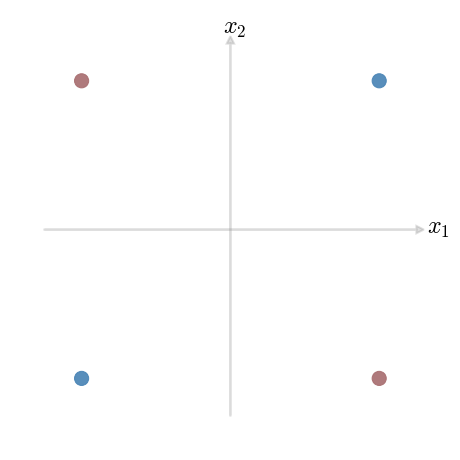

In [19]:
prob1plot()

**Q**: Is this set of training data linearly separable in the traditional sense? 

**Q**: Consider applying the quadratic kernel 

$$
K({\bf x}, {\bf z}) = \left({\bf x}^T{\bf z} + 1\right)^2
$$

What does the derived feature vector, $\phi({\bf x})$, associated with this kernel look like?  You can do this by expanding the $K({\bf x}, {\bf z})$ in terms of the features of ${\bf x}$ and ${\bf z}$ and then rearranging things so it looks like the dot product $\phi({\bf x})^T\phi({\bf z})$

**Q**: How many features are there in the higher dimensional space? 

**Q**: Can you see a pair of features in the derived feature space that would allow the data to linearly separated? 

<br>
<br>
<br>
<br>

### Problem 2: SVMs and the Bias-Variance Trade-Off
***

Consider the standard soft-margin SVM with objective function 

$$
\min_{{\bf w}, b} \|{\bf w}\|^2 + C \sum_{i=1}^m \xi_i 
$$

**Q**: How does the choice of **kernel** function affect the bias/variance of the model?  



**Q**: Similarly, for a **fixed** kernel type, how does the value of $C$ affect the bias/variance of the model? 

<br>
<br>
<br>
<br>

### Problem 3: Parameter Tuning, Accuracy, and Cross-Validation 
***

Any support vector machine classifier will have at least one parameter that needs to be tuned based on the training data.  The guaranteed parameter is the $C$ that appears in front of the slack variable term in the primal objective function, i.e. 

$$
\min_{{\bf w}, b, {\bf \xi}} \frac{1}{2}\|{\bf w}\|^2 + C \sum_{i=1}^m \xi_i
$$

If you use a kernel fancier than the linear kernel (i.e. the traditional non-kernelized SVM) then you will likely have other parameters as well. For instance in the polynomial kernel $K({\bf x}, {\bf z}) = ({\bf x}^T{\bf z} + c)^p$ you have to select the shift $c$ and the polynomial degree $p$.  Similarly the rbf kernel

$$
K({\bf x}, {\bf z}) = \exp\left[-\gamma\|{\bf x} - {\bf z}\|^2\right]
$$

has one tuning parameter, namely $\gamma$, which controls how fast the similarity measure drops off with distance between ${\bf x}$ and ${\bf z}$. 

For our examples we'll consider the rbf kernel, which gives us two parameters to tune, namely $C$ and $\gamma$. 

Consider the following two dimensional data

In [ ]:
Xtrain, ytrain = prob2GenData(N=300, seed=1235)
plotData(Xtrain, ytrain)

The following code trains an SVM model with an rbf kernel.  Play around with the parameters $C$ and $\gamma$ and see how this affects the decision and support vector boundaries. 

In [ ]:
clf = SVC(kernel="rbf", C=4, gamma=3)
plotSVM(Xtrain, ytrain, clf)

Before we can decide what good parameters are, we have to know what *good* means.  One idea would be to partition your data into a training set and a **validation** set, train your SVM model on the training data, and then compute the accuracy of the model on the validation set.  Accuracy is typically computed as 

$$
\texttt{score} = \frac{\texttt{# correctly labeled points}}{\texttt{# validation points}}
$$

We can easily compute this accuracy on the training data using our trained model as follows: 


In [ ]:
print "Accuracy on training data = ", clf.score(Xtrain, ytrain)

OK, that's pretty good!  Go back and play with the parameters in the SVM classifier and see what happens to the accuracy.  Did you hone in on a good set of parameters?  

OK.  So maybe you found a good set of parameters that yields a good accuracy on the training set.  But is this really what we're after?  Remember, our goal is to take our model and make predictions on future unseen data.  If we tweak our parameters with the accuracy on the training set in mind, it's likely that we will **overfit** the training data, and our model may not generalize to unseen data.  Let's generate some new data from the same distribution and see how our trained model performs. 

In [ ]:
Xvalid, yvalid = prob2GenData(N=100, seed=1235)
print "Accuracy on validation data = ", clf.score(Xvalid, yvalid)

OK, that's not too bad.  It's definite a lower accuracy score than on the training data, but we kind of expect this.  Go back and and tune the parameters some more with the goal of increasing the accuracy on the validation data instead.

Were you able to do better?  If so, **COOL**!  

**Q**: After parameter tuning we managed to get a pretty good accuracy on the validation data.  But can we really expect a similar accuracy on data that we'll see in the future? 

Let's get a new set of completely unseen data and test the SVM model on that. 

In [ ]:
Xtest, ytest = prob2GenData(N=100, seed=1241)
print "Accuracy on test data = ", clf.score(Xtest, ytest)

Here, because we've been using simulated data we've been able to generate new data as needed on the fly.  In reality you're usually given a set of labeled training data and that's it.  You can then partition your labeled data into training, validation, and test data and run your experiments. Typically the size of the split is **60%** training data, **20%** validation data, and **20%** test data. However, other splits are common as well. 

What do you do if you have such little data that you can't afford to set aside 40% of it for validation and testing?  One popular solution is something called **cross-validation**.  In this case you would still set aside 20% of the data as a final test set, but you get to keep the other 20% in the training set.  A popular form of cross-validation called **K-Folds** cross-validation works as follows 

- Divide your training data into $K$ "folds" equal size sets
- Loop over each of the folds and treat it as a hold-out set, while training on the other $K-$ folds 
- Compute the accuracy score for each of the $K$ models on the held-out data 
- Estimate the accuracy for your choice of parameters as the mean of the accuracy of the $K$ tests

Let's see this in action for the example above. 

In [ ]:
clf = SVC(kernel='rbf', C=4, gamma=3)
scores = cross_val_score(clf, Xtrain, ytrain, cv=5)

We can either look at the individual accuracies across each of the folds: 

In [ ]:
print scores

What we generally want though is an overall accuracy score for our model with our chosen set of parameter, which we can get just by taking the mean: 

In [ ]:
print "Mean Accuracy in Cross-Validation = ", scores.mean()

<br>
<br>
<br>
<br>

### Problem 4: Automating the Parameter Search 
***

On the previous problem we were able to choose some OK parameters just by hand-tuning.  But in real life (where time is money) it would be better to do something a little more automated.  One common thing to do is a **grid-search** over a predefined range of the parameters.  In this case you will loop over all possible combinations of parameters, estimate the accuracy of your model (using, say, K-Folds cross-validation) and then choose the parameter combination that produces the highest validation accuracy. 

Below is an experiment where we search over a logarithmic range between $10^{-2}$ and $10^{10}$ for $C$ and a range between $10^{-9}$ and $10^{3}$ for $\gamma$.  For the accuracy measure we use K-Folds CV with $K=3$. 

In [ ]:
crng = np.logspace(-2,10,13)
grng = np.logspace(-9,3,13)
param_grid = dict(gamma=grng, C=crng)
grid = GridSearchCV(SVC(kernel="rbf"), param_grid=param_grid, cv=3)
grid.fit(Xtrain, ytrain)

The following function plots a heatmap that shows the validation accuracy for each parameter combination.  Which one looks the best to you? 

In [ ]:
plotGrid(grid)

The GridSearchSV object stores (among other things) the best combination of parameters

In [ ]:
grid.best_params_

and the accuracy score achieved by the best set of parameters. 

In [ ]:
grid.best_score_

It also stores the classifier with the best parameters, which we can pass into our plotSVM function to see the result. 

In [ ]:
plotSVM(Xtrain, ytrain, grid.best_estimator_)



<br>
<br>
<br>
<br>
### Notebook Solutions
<br>
<br>

### Problem 1: Polynomial Kernels 
***

Consider the following labeled data (with red and blue indicating the positive and negative labels, respectively)


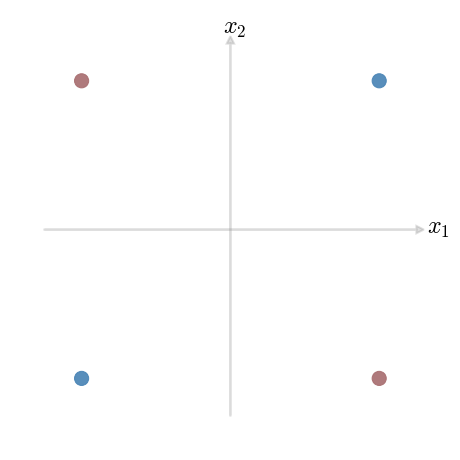

In [2]:
prob1plot()

**Q**: Is this set of training data linearly separable in the traditional sense? 

**A**: Clearly not. 

**Q**: Consider applying the quadratic kernel 

$$
K({\bf x}, {\bf z}) = \left({\bf x}^T{\bf z} + 1\right)^2
$$

What does the derived feature vector, $\phi({\bf x})$, associated with this kernel look like?  You can do this by expanding the $K({\bf x}, {\bf z})$ in terms of the features of ${\bf x}$ and ${\bf z}$ and then rearranging things so it looks like the dot product $\phi({\bf x})^T\phi({\bf z})$

**A**: We have 

\begin{array}{rcl}
K({\bf x}, {\bf z}) &=& (x_1z_1 + x_2z_2 + 1)^2  \\
 &=& (x_1x_1)(z_1z_1) + 2(x_1x_2)(z_1z_2) + (x_2x_2)(z_2z_2) +2x_1z_1 + 2x_2z_2 + 1 \\
 &=& \phi({\bf x})^T\phi({\bf z})
\end{array}

where $\phi({\bf x}) = 
\left[
\begin{array}{c}
x_1x_1 \\
\sqrt{2}x_1x_2\\
x_2x_2 \\
\sqrt{2}x_1 \\
\sqrt{2}x_2 \\
1
\end{array}
\right]
$.  

**Q**: How many features are there in the higher dimensional space? 

**A**:  In this configuration there are 6 features in the derived feature space.  However, the last feature is constant and doesn't depend on the data.  So we could also say there are 5 useful features in the derived space. 

**Q**: Can you see a pair of features in the derived feature space that would allow the data to linearly separated? 

**A**:  Plotting the four points in the $\sqrt{2}x_1$ vs. $\sqrt{2}x_1x_2$ plane we have 

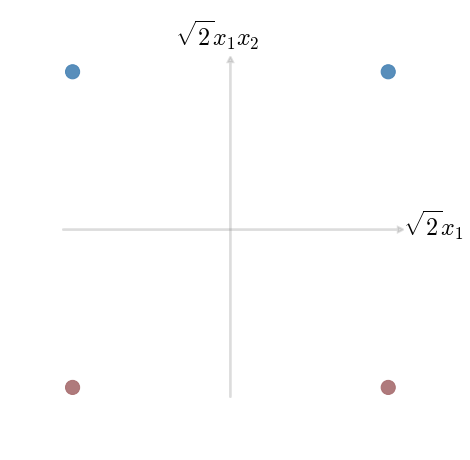

In [3]:
prob1sol()

Here we see that the data is easily linearly separable in this space.  In fact, from the original data you can tell that the training data can be linearly separated by considering **only** the sign on the derived $\sqrt{2}x_1x_2$ feature.  A weight vector in the derived feature space that would define a separating hyperplane would simply be 

$$
{\bf w} = \left[
\begin{array}{c}
0 \\
1 \\
0 \\
0 \\
0 \\
0 \\
\end{array}
\right]
$$

Note that this is probably not the optimal linear hyperplane defined by SVM with the polynomial kernel but it is **a** separating hyperplane. 

<br>
<br>
<br>
<br>

### Problem 2: SVMs and the Bias-Variance Trade-Off
***

Consider the standard soft-margin SVM with objective function 

$$
\min_{{\bf w}, b} \|{\bf w}\|^2 + C \sum_{i=1}^m \xi_i 
$$

**Q**: How does the choice of **kernel** function affect the bias/variance of the model?  



**A**: The complexity of the kernel function has a large affect on bias/variance.  For a linear kernel the SVM is a linear classifier which has high bias (can't capture distributions with high nonlinearity) and low variance because the orientation of the linear decision boundary is not terribly sensitive to the training data.  On the other hand an RBF kernel is very complex.  It has low bias because it can potentially capture extreme nonlinearity in the data distribution, but it has high variance because it is flexible enough to fit the training data extremely well, even if that leads to poor performance on the test data. 

**Q**: Similarly, for a **fixed** kernel type, how does the value of $C$ affect the bias/variance of the model? 

**A**: The value of $C$ in the soft-margin SVM can also affect bias/variance.  Remember that the penalty term involving $C$ affects how much the model will work to put all training examples on the correct side of the support vector boundaries.  If $C$ is large it will work very hard to classify each training example perfectly.  This will lead to a high-variance method with lower bias.  On the other hand if $C$ is small then the model is perfectly willing to misclassify some training examples.  This leads to a higher bias method with lower variance. 


<br>
<br>
<br>
<br>

### Problem 3: Parameter Tuning, Accuracy, and Cross-Validation 
***

Any support vector machine classifier will have at least one parameter that needs to be tuned based on the training data.  The guaranteed parameter is the $C$ that appears in front of the slack variable term in the primal objective function, i.e. 

$$
\min_{{\bf w}, b, {\bf \xi}} \frac{1}{2}\|{\bf w}\|^2 + C \sum_{i=1}^m \xi_i
$$

If you use a kernel fancier than the linear kernel (i.e. the traditional non-kernelized SVM) then you will likely have other parameters as well. For instance in the polynomial kernel $K({\bf x}, {\bf z}) = ({\bf x}^T{\bf z} + c)^p$ you have to select the shift $c$ and the polynomial degree $p$.  Similarly the rbf kernel

$$
K({\bf x}, {\bf z}) = \exp\left[-\gamma\|{\bf x} - {\bf z}\|^2\right]
$$

has one tuning parameter, namely $\gamma$, which controls how fast the similarity measure drops off with distance between ${\bf x}$ and ${\bf z}$. 

For our examples we'll consider the rbf kernel, which gives us two parameters to tune, namely $C$ and $\gamma$. 

Consider the following two dimensional data

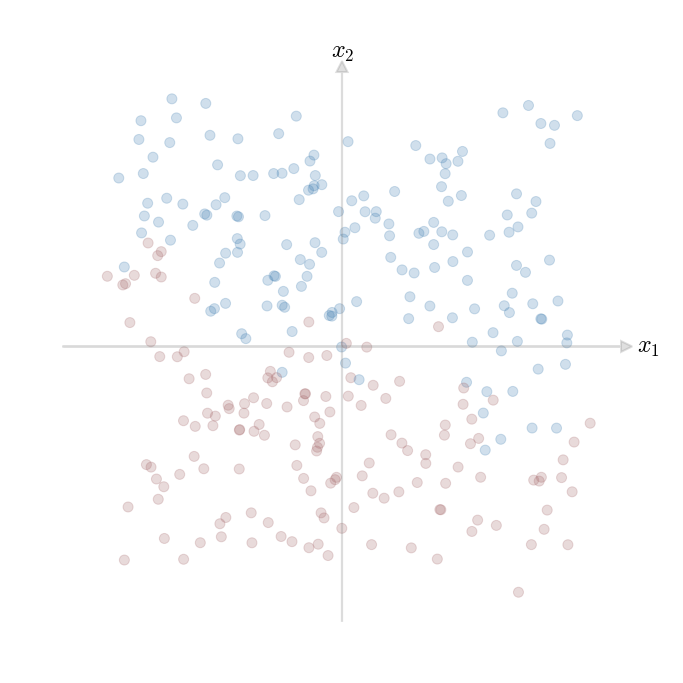

In [4]:
Xtrain, ytrain = prob2GenData(N=300, seed=1235)
plotData(Xtrain, ytrain)

The following code trains an SVM model with an rbf kernel.  Play around with the parameters $C$ and $\gamma$ and see how this affects the decision and support vector boundaries. 

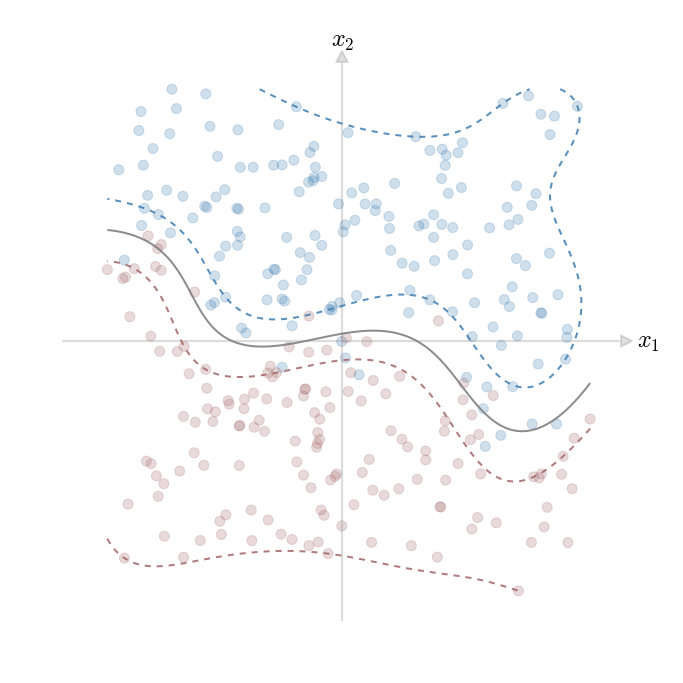

In [5]:
clf = SVC(kernel="rbf", C=4, gamma=3)
plotSVM(Xtrain, ytrain, clf)

Before we can decide what good parameters are, we have to know what *good* means.  One idea would be to partition your data into a training set and a **validation** set, train your SVM model on the training data, and then compute the accuracy of the model on the validation set.  Accuracy is typically computed as 

$$
\texttt{score} = \frac{\texttt{# correctly labeled points}}{\texttt{# validation points}}
$$

We can easily compute this accuracy on the training data using our trained model as follows: 


In [6]:
print "Accuracy on training data = ", clf.score(Xtrain, ytrain)

Accuracy on training data =  0.95


OK, that's pretty good!  Go back and play with the parameters in the SVM classifier and see what happens to the accuracy.  Did you hone in on a good set of parameters?  

OK.  So maybe you found a good set of parameters that yields a good accuracy on the training set.  But is this really what we're after?  Remember, our goal is to take our model and make predictions on future unseen data.  If we tweak our parameters with the accuracy on the training set in mind, it's likely that we will **overfit** the training data, and our model may not generalize to unseen data.  Let's generate some new data from the same distribution and see how our trained model performs. 

In [7]:
Xvalid, yvalid = prob2GenData(N=100, seed=1235)
print "Accuracy on validation data = ", clf.score(Xvalid, yvalid)

Accuracy on validation data =  0.93


OK, that's not too bad.  It's definite a lower accuracy score than on the training data, but we kind of expect this.  Go back and and tune the parameters some more with the goal of increasing the accuracy on the validation data instead.

Were you able to do better?  If so, **COOL**!  

**Q**: After parameter tuning we managed to get a pretty good accuracy on the validation data.  But can we really expect a similar accuracy on data that we'll see in the future? 

**A**:  NO!  Although it seems like our model is completely independent from the validation data (after all, we trained our model on the training data) the fact that we then went back and did parameter tuning on on the validation set is **also a form of model training**!  In other words, the validation set has in some sense become part of the training data.  To truly predict how well your model will do on unseen data, you need to find a **NEW** set of data, which we usually call the **test** data, and test your model on that.  

Let's get a new set of completely unseen data and test the SVM model on that. 

In [8]:
Xtest, ytest = prob2GenData(N=100, seed=1241)
print "Accuracy on test data = ", clf.score(Xtest, ytest)

Accuracy on test data =  0.88


Here, because we've been using simulated data we've been able to generate new data as needed on the fly.  In reality you're usually given a set of labeled training data and that's it.  You can then partition your labeled data into training, validation, and test data and run your experiments. Typically the size of the split is **60%** training data, **20%** validation data, and **20%** test data. However, other splits are common as well. 

What do you do if you have such little data that you can't afford to set aside 40% of it for validation and testing?  One popular solution is something called **cross-validation**.  In this case you would still set aside 20% of the data as a final test set, but you get to keep the other 20% in the training set.  A popular form of cross-validation called **K-Folds** cross-validation works as follows 

- Divide your training data into $K$ "folds" equal size sets
- Loop over each of the folds and treat it as a hold-out set, while training on the other $K-$ folds 
- Compute the accuracy score for each of the $K$ models on the held-out data 
- Estimate the accuracy for your choice of parameters as the mean of the accuracy of the $K$ tests

Let's see this in action for the example above. 

In [9]:
clf = SVC(kernel='rbf', C=4, gamma=3)
scores = cross_val_score(clf, Xtrain, ytrain, cv=5)

We can either look at the individual accuracies across each of the folds: 

In [10]:
print scores

[ 0.91803279  0.93442623  0.96666667  0.89830508  0.94915254]


What we generally want though is an overall accuracy score for our model with our chosen set of parameter, which we can get just by taking the mean: 

In [11]:
print "Mean Accuracy in Cross-Validation = ", scores.mean()

Mean Accuracy in Cross-Validation =  0.933316662036


<br>
<br>
<br>
<br>

### Problem 4: Automating the Parameter Search 
***

On the previous problem we were able to choose some OK parameters just by hand-tuning.  But in real life (where time is money) it would be better to do something a little more automated.  One common thing to do is a **grid-search** over a predefined range of the parameters.  In this case you will loop over all possible combinations of parameters, estimate the accuracy of your model (using, say, K-Folds cross-validation) and then choose the parameter combination that produces the highest validation accuracy. 

Below is an experiment where we search over a logarithmic range between $10^{-2}$ and $10^{10}$ for $C$ and a range between $10^{-9}$ and $10^{3}$ for $\gamma$.  For the accuracy measure we use K-Folds CV with $K=3$. 

In [12]:
crng = np.logspace(-2,10,13)
grng = np.logspace(-9,3,13)
param_grid = dict(gamma=grng, C=crng)
grid = GridSearchCV(SVC(kernel="rbf"), param_grid=param_grid, cv=3)
grid.fit(Xtrain, ytrain)

GridSearchCV(cv=3, error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'C': array([  1.00000e-02,   1.00000e-01,   1.00000e+00,   1.00000e+01,
         1.00000e+02,   1.00000e+03,   1.00000e+04,   1.00000e+05,
         1.00000e+06,   1.00000e+07,   1.00000e+08,   1.00000e+09,
         1.00000e+10]), 'gamma': array([  1.00000e-09,   1.00000e-08,   1.00000e-07,   1.00000e-06,
         1.00000e-05,   1.00000e-04,   1.00000e-03,   1.00000e-02,
         1.00000e-01,   1.00000e+00,   1.00000e+01,   1.00000e+02,
         1.00000e+03])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

The following function plots a heatmap that shows the validation accuracy for each parameter combination.  Which one looks the best to you? 

//anaconda/lib/python2.7/site-packages/sklearn/model_selection/_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


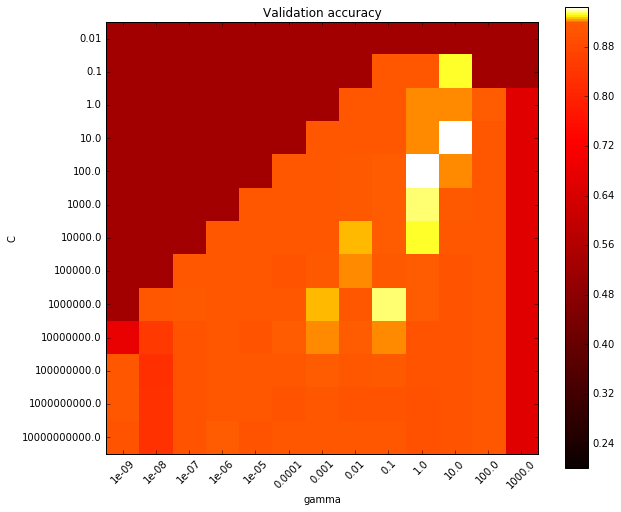

In [13]:
plotGrid(grid)

The GridSearchSV object stores (among other things) the best combination of parameters

In [16]:
grid.best_params_

{'C': 10.0, 'gamma': 10.0}

and the accuracy score achieved by the best set of parameters. 

In [17]:
grid.best_score_

0.94333333333333336

It also stores the classifier with the best parameters, which we can pass into our plotSVM function to see the result. 

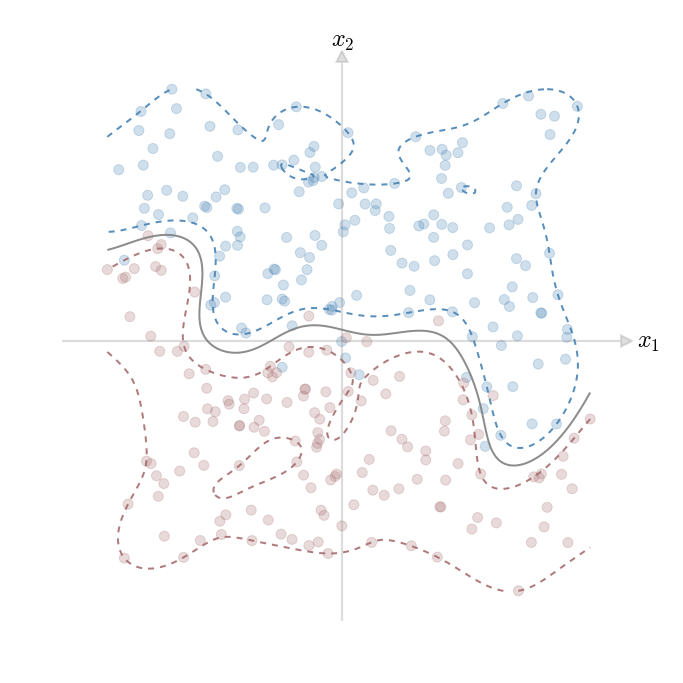

In [18]:
plotSVM(Xtrain, ytrain, grid.best_estimator_)

<br><br><br><br>
<br><br><br><br>
<br><br><br><br>

### Helper Functions
***

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.svm import LinearSVC, SVC
from sklearn.datasets import make_blobs
from matplotlib.colors import Normalize
%matplotlib inline

def prob1plot():
    X = np.array([[1,1], [1,-1], [-1,1], [-1,-1]])
    y = np.array([1, -1, -1, 1])
    mycolors = {"blue": "steelblue", "red": "#a76c6e", "green": "#6a9373"}
    msize=200
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111)
    colors = [mycolors["blue"] if yi==1 else mycolors["red"] for yi in y]
    plt.scatter(X[:,0],X[:,1], marker='o', color=colors, s=msize, alpha=0.90)
    plt.arrow(-1.25,0,2.5,0, head_length=0.05, head_width=0.05, fc="gray", ec="gray", lw=2, alpha=0.25)
    plt.arrow(0,-1.25,0,2.5, head_length=0.05, head_width=0.05, fc="gray", ec="gray", lw=2, alpha=0.25)
    ax.text(1.32, -.025, r"$x_1$", fontsize=24)
    ax.text(-.05, 1.32, r"$x_2$", fontsize=24)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    plt.xticks([], fontsize=16)
    plt.yticks([], fontsize=16)
    
def prob1sol():
    X = np.array([[1,1], [1,-1], [-1,1], [-1,-1]])
    y = np.array([1, -1, -1, 1])
    
    P = np.zeros((X.shape[0], 6))
    P[:,0] = X[:,0] * X[:,0]
    P[:,1] = np.sqrt(2)*X[:,0] * X[:,1]
    P[:,2] = X[:,1] * X[:,1]
    P[:,3] = np.sqrt(2)*X[:,0]
    P[:,4] = np.sqrt(2)*X[:,1]
    P[:,5] = 1 + 0.0 * X[:,1]
    
    mycolors = {"blue": "steelblue", "red": "#a76c6e", "green": "#6a9373"}
    msize=200
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111)
    colors = [mycolors["blue"] if yi==1 else mycolors["red"] for yi in y]
    plt.scatter(P[:,3],P[:,1], marker='o', color=colors, s=msize, alpha=0.90)
    plt.arrow(-1.5,0,3.0,0, head_length=0.05, head_width=0.05, fc="gray", ec="gray", lw=2, alpha=0.25)
    plt.arrow(0,-1.5,0,3.0, head_length=0.05, head_width=0.05, fc="gray", ec="gray", lw=2, alpha=0.25)
    ax.text(1.55, -.05, r"$\sqrt{2}x_1$", fontsize=24)
    ax.text(-.5, 1.65, r"$\sqrt{2}x_1x_2$", fontsize=24)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    plt.xticks([], fontsize=16)
    plt.yticks([], fontsize=16) 
    

def prob2GenData(N=100, seed=1235):
    
    np.random.seed(seed)
    
    X = np.random.uniform(-1,1,(N,2))
    y = np.array([1 if y-x > 0 else -1 for (x,y) in zip(X[:,0]**2 * np.sin(2*np.pi*X[:,0]), X[:,1])])
    X = X + np.random.normal(0,.1,(N,2))
    
    return X, y

def plotData(X, y):
    mycolors = {"blue": "steelblue", "red": "#a76c6e", "green": "#6a9373"}
    msize=100
    fig = plt.figure(figsize=(12,12))
    ax = fig.add_subplot(111)
    colors = [mycolors["blue"] if yi==1 else mycolors["red"] for yi in y]
    plt.scatter(X[:,0],X[:,1], marker='o', color=colors, s=msize, alpha=0.25)
    plt.arrow(-1.25,0,2.5,0, head_length=0.05, head_width=0.05, fc="gray", ec="gray", lw=2, alpha=0.25)
    plt.arrow(0,-1.25,0,2.5, head_length=0.05, head_width=0.05, fc="gray", ec="gray", lw=2, alpha=0.25)
    z = np.linspace(0.25,3.5,10)
    ax.text(1.32, -.025, r"$x_1$", fontsize=24)
    ax.text(-.05, 1.32, r"$x_2$", fontsize=24)
    plt.xlim([-1.50,1.50])
    plt.ylim([-1.50,1.550])
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    plt.xticks([], fontsize=16)
    plt.yticks([], fontsize=16)
    
def plotSVM(X, y, clf): 
    msize=100
    mycolors = {"blue": "steelblue", "red": "#a76c6e", "green": "#6a9373"}
    fig = plt.figure(figsize=(12,12))
    ax = fig.add_subplot(111)
    colors = [mycolors["blue"] if yi==1 else mycolors["red"] for yi in y]
    plt.scatter(X[:,0],X[:,1], marker='o', color=colors, s=msize, alpha=0.25)
    plt.arrow(-1.25,0,2.5,0, head_length=0.05, head_width=0.05, fc="gray", ec="gray", lw=2, alpha=0.25)
    plt.arrow(0,-1.25,0,2.5, head_length=0.05, head_width=0.05, fc="gray", ec="gray", lw=2, alpha=0.25)
    z = np.linspace(0.25,3.5,10)
    ax.text(1.32, -.025, r"$x_1$", fontsize=24)
    ax.text(-.05, 1.32, r"$x_2$", fontsize=24)
    plt.xlim([-1.50,1.50])
    plt.ylim([-1.50,1.50])
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    plt.xticks([], fontsize=16)
    plt.yticks([], fontsize=16)
    
    clf.fit(X,y)

    x_min = X[:, 0].min()+.00
    x_max = X[:, 0].max()-.00
    y_min = X[:, 1].min()+.00
    y_max = X[:, 1].max()-.00

    colors = [mycolors["blue"] if yi==1 else mycolors["red"] for yi in y]

    XX, YY = np.mgrid[x_min:x_max:200j, y_min:y_max:200j]
    Z = clf.decision_function(np.c_[XX.ravel(), YY.ravel()])

    # Put the result into a color plot
    Z = Z.reshape(XX.shape)
    plt.contour(XX, YY, Z, colors=[mycolors["red"], "gray", mycolors["blue"]], linestyles=['--', '-', '--'],
                levels=[-1.0, 0, 1.0], linewidths=[2,2,2], alpha=0.9)
    

# This class and the following function were blatantly ripped off 
# from the sklearn tutorial entitled RBF SVM Parameters in the 
# sklearn documentation. 
class MidpointNormalize(Normalize):

    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y))
    
def plotGrid(grid):
    
    scores = [x[1] for x in grid.grid_scores_]
    scores = np.array(scores).reshape(len(crng), len(grng))

    plt.figure(figsize=(10, 8))
    plt.subplots_adjust(left=.2, right=0.95, bottom=0.15, top=0.95)
    plt.imshow(scores, interpolation='nearest', cmap=plt.cm.hot,
               norm=MidpointNormalize(vmin=0.2, midpoint=0.92))
    plt.xlabel('gamma')
    plt.ylabel('C')
    plt.colorbar()
    plt.xticks(np.arange(len(grng)), grng, rotation=45)
    plt.yticks(np.arange(len(crng)), crng)
    plt.title('Validation accuracy')
    plt.show()
    
from IPython.core.display import HTML
HTML("""
<style>
.MathJax nobr>span.math>span{border-left-width:0 !important};
</style>
""")